In [1]:
!pip3 install folium

In [2]:
import kaggle
import zipfile
import os
from kaggle.api.kaggle_api_extended import KaggleApi
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import requests
import json


# Standard libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
import json
import requests
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

# Utilities
from viz import *
#from custom_transformers import *
#from ml_utils import *

# DataPrep
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
#import lightgbm as lgb

In [3]:
current_directory = os.getcwd()
folder = 'csvFiles'

def data_overview(df):
    summary = pd.DataFrame({
        'feature': df.columns,
        'qtd_null': df.isnull().sum(),
        'percent_null': df.isnull().mean() * 100,
        'dtype': df.dtypes,
        'qtd_cat': df.astype('str').nunique()
    })
    return summary

def format_spines(ax, right_border=True):
    ax.spines['top'].set_visible(False)
    if right_border:
        ax.spines['right'].set_visible(False)
    else:
        ax.spines['right'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')
    ax.tick_params(axis='x', colors='dimgrey')
    ax.tick_params(axis='y', colors='dimgrey')

class AnnotateBars:
    def __init__(self, n_dec=0, font_size=10, color='black'):
        self.n_dec = n_dec
        self.font_size = font_size
        self.color = color

    def horizontal(self, ax, space=5):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()
            value = round(p.get_width(), self.n_dec)
            ax.text(_x, _y, f'{value}', ha="left", va='bottom', fontsize=self.font_size, color=self.color)

def single_countplot(data, x, ax=None, **kwargs):
    sns.countplot(data=data, x=x, ax=ax, **kwargs)

Fetching dataset from kaggle using kaggle-api

In [4]:
""" api = KaggleApi()
api.authenticate()


Files = os.path.join(current_directory, folder)
dataset_name = 'olistbr/brazilian-ecommerce'
download_path = Files
api.dataset_download_files(dataset_name, path=download_path, unzip=True)
print("Download done") """

' api = KaggleApi()\napi.authenticate()\n\n\nFiles = os.path.join(current_directory, folder)\ndataset_name = \'olistbr/brazilian-ecommerce\'\ndownload_path = Files\napi.dataset_download_files(dataset_name, path=download_path, unzip=True)\nprint("Download done") '

Reading data

In [5]:
dataset_name = [
    'olist_customers_dataset', 
    'olist_geolocation_dataset', 
    'olist_order_items_dataset', 
    'olist_order_payments_dataset', 
    'olist_order_reviews_dataset', 
    'olist_orders_dataset', 
    'olist_products_dataset', 
    'olist_sellers_dataset', 
    'product_category_name_translation']

csvFiles = os.path.join(current_directory, 'csvFiles')

for i in dataset_name:
    file_path = os.path.join(csvFiles, f'{i}.csv')
    globals()[i] = pd.read_csv(file_path)

for i in dataset_name:
    print(i)
    print(pd.DataFrame(globals()[i]).head(2))

olist_customers_dataset
                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
olist_geolocation_dataset
   geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                         1037       -23.545621       -46.639292   
1                         1046       -23.546081       -46.644820   

  geolocation_city geolocation_state  
0        sao paulo                SP  
1        sao paulo                SP  
olist_order_items_dataset
                           order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   

               

check for data consistancy

In [6]:
data_info = pd.DataFrame({})
data_info['dataset'] = dataset_name
data_info['n_rows'] = [pd.DataFrame(globals()[df]).shape[0] for df in dataset_name]
data_info['n_cols'] = [pd.DataFrame(globals()[df]).shape[1] for df in dataset_name]
data_info['null_amount'] = [pd.DataFrame(globals()[df]).isnull().sum().sum() for df in dataset_name]
data_info['qty_null_columns'] = [len([col for col, null in pd.DataFrame(globals()[df]).isnull().sum().items() if null > 0]) for df in dataset_name]
data_info['null_columns'] = [', '.join([col for col, null in pd.DataFrame(globals()[df]).isnull().sum().items() if null > 0]) for df in dataset_name]
data_info['cols_Name'] = [pd.DataFrame(globals()[df]).columns for df in dataset_name]

data_info.style.set_caption("Datasets Info").background_gradient()

Analyzing data and cleaning up

In [7]:
for i in dataset_name:
    df = pd.DataFrame(globals()[i])
    df.drop_duplicates()

dfs_summary = []

for name in dataset_name:
    df = globals()[name]
    num_cols = df.shape[1]
    name_col = [name] * num_cols
    dfs_summary.append(data_overview(df))
    dfs_summary[-1]['dataset_name'] = name_col

df_overview = pd.concat(dfs_summary, ignore_index=True)
df_overview = df_overview.loc[:, ['dataset_name', 'feature', 'qtd_null', 'percent_null', 'dtype', 'qtd_cat']]
df_overview

dataset_name                        feature  \
0             olist_customers_dataset                    customer_id   
1             olist_customers_dataset             customer_unique_id   
2             olist_customers_dataset       customer_zip_code_prefix   
3             olist_customers_dataset                  customer_city   
4             olist_customers_dataset                 customer_state   
5           olist_geolocation_dataset    geolocation_zip_code_prefix   
6           olist_geolocation_dataset                geolocation_lat   
7           olist_geolocation_dataset                geolocation_lng   
8           olist_geolocation_dataset               geolocation_city   
9           olist_geolocation_dataset              geolocation_state   
10          olist_order_items_dataset                       order_id   
11          olist_order_items_dataset                  order_item_id   
12          olist_order_items_dataset                     product_id   
13          olist_order_items_dataset                      seller_id   
14          olist_order_items_dataset            shipping_limit_date   
15          olist_order_items_dataset                          price   
16          olist_order_items_dataset                  freight_value   
17       olist_order_payments_dataset                       order_id   
18       olist_order_payments_dataset             payment_sequential   
19       olist_order_payments_dataset                   payment_type   
20       olist_order_payments_dataset           payment_installments   
21       olist_order_payments_dataset                  payment_value   
22        olist_order_reviews_dataset                      review_id   
23        olist_order_reviews_dataset                       order_id   
24        olist_order_reviews_dataset                   review_score   
25        olist_order_reviews_dataset           review_comment_title   
26        olist_order_reviews_dataset         review_comment_message   
27        olist_order_reviews_dataset           review_creation_date   
28        olist_order_reviews_dataset        review_answer_timestamp   
29               olist_orders_dataset                       order_id   
30               olist_orders_dataset                    customer_id   
31               olist_orders_dataset                   order_status   
32               olist_orders_dataset       order_purchase_timestamp   
33               olist_orders_dataset              order_approved_at   
34               olist_orders_dataset   order_delivered_carrier_date   
35               olist_orders_dataset  order_delivered_customer_date   
36               olist_orders_dataset  order_estimated_delivery_date   
37             olist_products_dataset                     product_id   
38             olist_products_dataset          product_category_name   
39             olist_products_dataset            product_name_lenght   
40             olist_products_dataset     product_description_lenght   
41             olist_products_dataset             product_photos_qty   
42             olist_products_dataset               product_weight_g   
43             olist_products_dataset              product_length_cm   
44             olist_products_dataset              product_height_cm   
45             olist_products_dataset               product_width_cm   
46              olist_sellers_dataset                      seller_id   
47              olist_sellers_dataset         seller_zip_code_prefix   
48              olist_sellers_dataset                    seller_city   
49              olist_sellers_dataset                   seller_state   
50  product_category_name_translation          product_category_name   
51  product_category_name_translation  product_category_name_english   

    qtd_null  percent_null    dtype  qtd_cat  
0          0      0.000000   object    99441  
1          0      0.000000   object    96096  
2          0      0.000000    int64    14994  
3          0      0.

Performing EDA

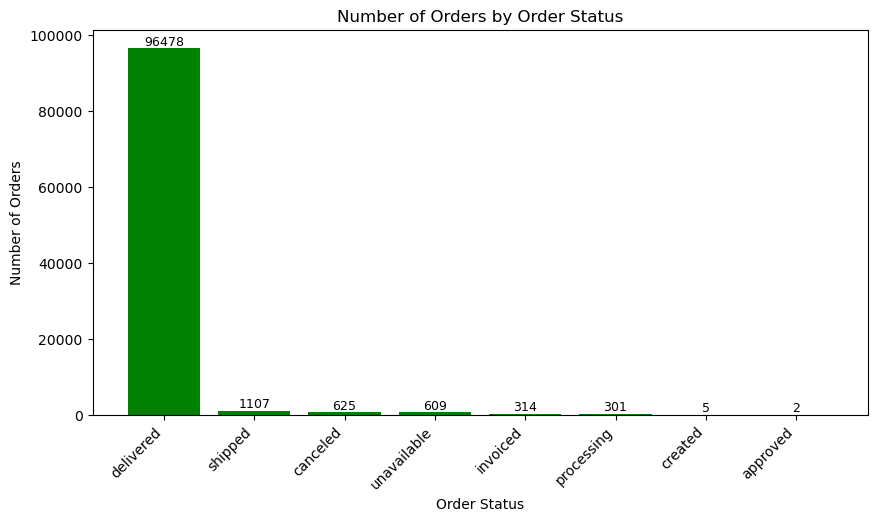

In [8]:
dfOrder = olist_orders_dataset.groupby('order_status')['order_id'].count()
dfOrder = dfOrder.sort_values(ascending=False)

plt.figure(figsize=(10, 5))
bars = plt.bar(dfOrder.index, dfOrder.values, color='green')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center', fontsize=9)

plt.xlabel('Order Status')
plt.ylabel('Number of Orders')
plt.title('Number of Orders by Order Status')
plt.xticks(rotation=45, ha='right')
plt.show()


order by year month and day of the week

In [9]:
cols = ['order_purchase_timestamp', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for i in cols:
    olist_orders_dataset[i] = pd.to_datetime(olist_orders_dataset[i])

olist_orders_dataset['order_purchase_year'] = olist_orders_dataset['order_purchase_timestamp'].apply(lambda x: x.year)
olist_orders_dataset['order_purchase_month'] = olist_orders_dataset['order_purchase_timestamp'].apply(lambda x: x.month)
olist_orders_dataset['order_purchase_month_name'] = olist_orders_dataset['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
olist_orders_dataset['order_purchase_year_month'] = olist_orders_dataset['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))
olist_orders_dataset['order_purchase_date'] = olist_orders_dataset['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

olist_orders_dataset['order_purchase_day'] = olist_orders_dataset['order_purchase_timestamp'].apply(lambda x: x.day)
olist_orders_dataset['order_purchase_dayofweek'] = olist_orders_dataset['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
olist_orders_dataset['order_purchase_dayofweek_name'] = olist_orders_dataset['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

olist_orders_dataset['order_purchase_hour'] = olist_orders_dataset['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
olist_orders_dataset['order_purchase_time_day'] = pd.cut(olist_orders_dataset['order_purchase_hour'], hours_bins, labels=hours_labels)

olist_orders_dataset

order_id                       customer_id  \
0      e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1      53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2      47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3      949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4      ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   
...                                 ...                               ...   
99436  9c5dedf39a927c1b2549525ed64a053c  39bd1228ee8140590ac3aca26f2dfe00   
99437  63943bddc261676b46f01ca7ac2f7bd8  1fca14ff2861355f6e5f14306ff977a7   
99438  83c1379a015df1e13d02aae0204711ab  1aa71eb042121263aafbe80c1b562c9c   
99439  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
99440  66dea50a8b16d9b4dee7af250b4be1a5  edb027a75a1449115f6b43211ae02a24   

      order_status order_purchase_timestamp    order_approved_at  \
0        delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1        delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2        delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3        delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4        delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   
...            ...                      ...                  ...   
99436    delivered      2017-03-09 09:54:05  2017-03-09 09:54:05   
99437    delivered      2018-02-06 12:58:58  2018-02-06 13:10:37   
99438    delivered      2017-08-27 14:46:43  2017-08-27 15:04:16   
99439    delivered      2018-01-08 21:28:27  2018-01-08 21:36:21   
99440    delivered      2018-03-08 20:57:30  2018-03-09 11:20:28   

      order_delivered_carrier_date order_delivered_customer_date  \
0              2017-10-04 19:55:00           2017-10-10 21:25:13   
1              2018-07-26 14:31:00           2018-08-07 15:27:45   
2              2018-08-08 13:50:00           2018-08-17 18:06:29   
3              2017-11-22 13:39:59           2017-12-02 00:28:42   
4              2018-02-14 19:46:34           2018-02-16 18:17:02   
...                            ...                           ...   
99436          2017-03-10 11:18:03           2017-03-17 15:08:01   
99437          2018-02-07 23:22:42           2018-02-28 17:37:56   
99438          2017-08-28 20:52:26           2017-09-21 11:24:17   
99439          2018-01-12 15:35:03           2018-01-25 23:32:54   
99440          2018-03-09 22:11:59           2018-03-16 13:08:30   

      order_estimated_delivery_date  order_purchase_year  \
0                        2017-10-18                 2017   
1                        2018-08-13                 2018   
2                        2018-09-04                 2018   
3                        2017-12-15                 2017   
4                        2018-02-26                 2018   
...                             ...                  ...   
99436                    2017-03-28                 2017   
99437                    2018-03-02                 2018   
99438                    2017-09-27                 2017   
99439                    2018-02-15                 2018   
99440                    2018-04-03                 2018   

       order_purchase_month order_purchase_month_name  \
0                        10                       Oct   
1                         7                       Jul   
2                         8                       Aug   
3                        11                       Nov   
4                         2                       Feb   
...                     ...                       ...   
99436                     3                       Mar   
99437                     2                       Feb   
99438                     8                       Aug   
99439                     1                       Jan   
99440                     3                       Mar   

      order_purchase_year_month order_purchase_date  order_purchas

/var/folders/89/0r9qyh0n08b8ytzm9swqrl_80000gn/T/ipykernel_23902/2397004834.py:32: UserWarning:

The figure layout has changed to tight



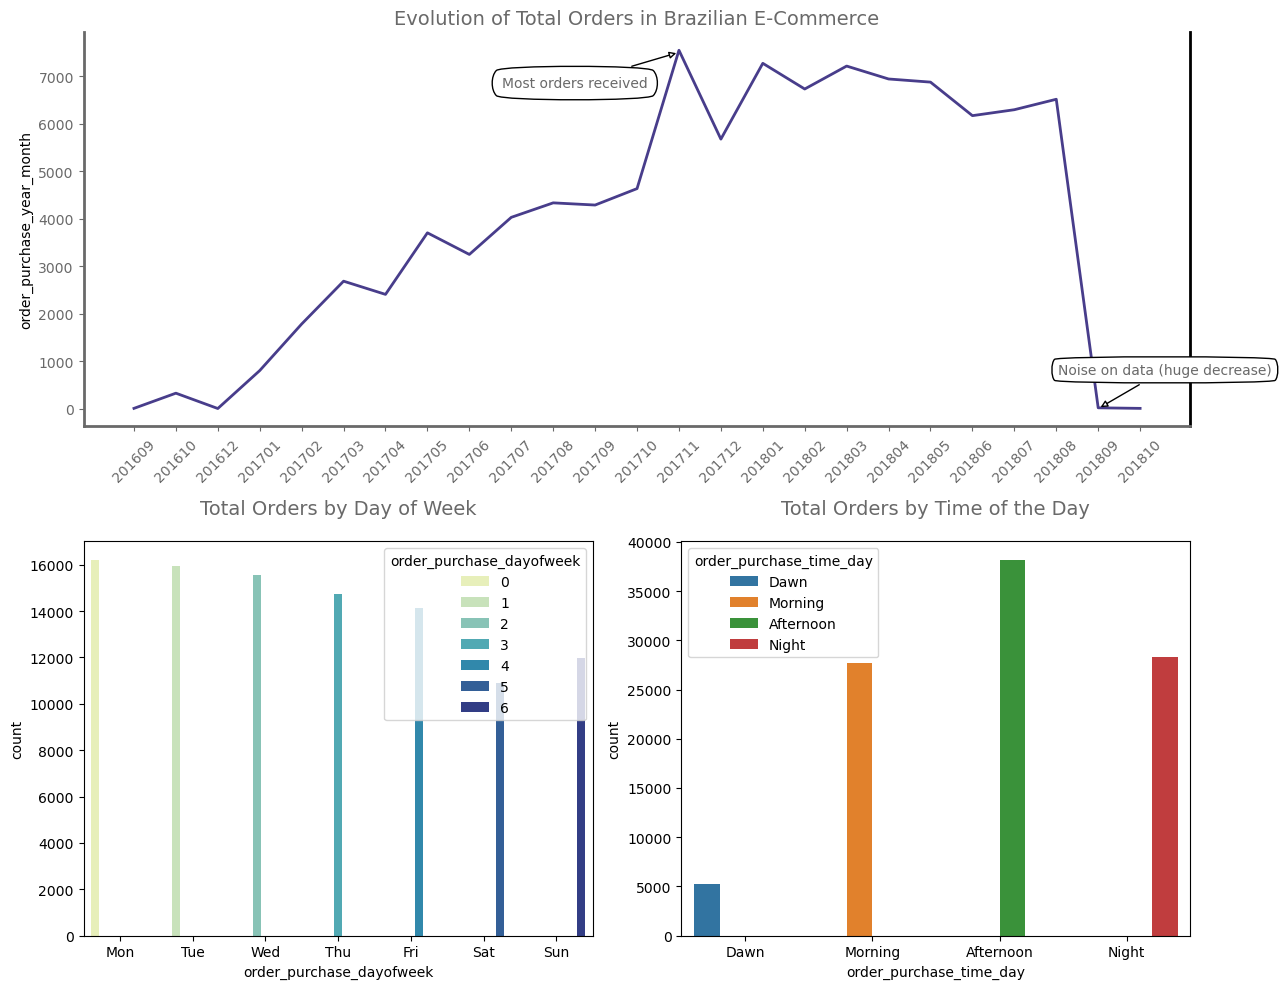

In [10]:
# Define a more visually appealing color palette
day_color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Plotting data with enhanced aesthetics
fig = plt.figure(constrained_layout=True, figsize=(13, 10))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Line plot with updated color and annotation positions
sns.lineplot(data=olist_orders_dataset['order_purchase_year_month'].value_counts().sort_index(), ax=ax1, color='darkslateblue', linewidth=2)
ax1.annotate(f'Most orders received', (13, 7500), xytext=(-75, -25), textcoords='offset points', 
             bbox=dict(boxstyle="round4", fc="w", pad=.8), arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.annotate(f'Noise on data (huge decrease)', (23, 0), xytext=(48, 25), textcoords='offset points', 
             bbox=dict(boxstyle="round4", fc="w", pad=.5), arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
format_spines(ax1, right_border=False)
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_title('Evolution of Total Orders in Brazilian E-Commerce', size=14, color='dimgrey')

# Barchart - Total of orders by day of week
sns.countplot(data=olist_orders_dataset, x='order_purchase_dayofweek', ax=ax2, hue='order_purchase_dayofweek', palette='YlGnBu')
weekday_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax2.set_xticklabels(weekday_label)
ax2.set_title('Total Orders by Day of Week', size=14, color='dimgrey', pad=20)

# Barchart - Total of orders by time of the day
sns.countplot(data=olist_orders_dataset, x='order_purchase_time_day', ax=ax3, hue='order_purchase_time_day', palette=day_color_list)
ax3.set_title('Total Orders by Time of the Day', size=14, color='dimgrey', pad=20)

plt.tight_layout()
plt.show()


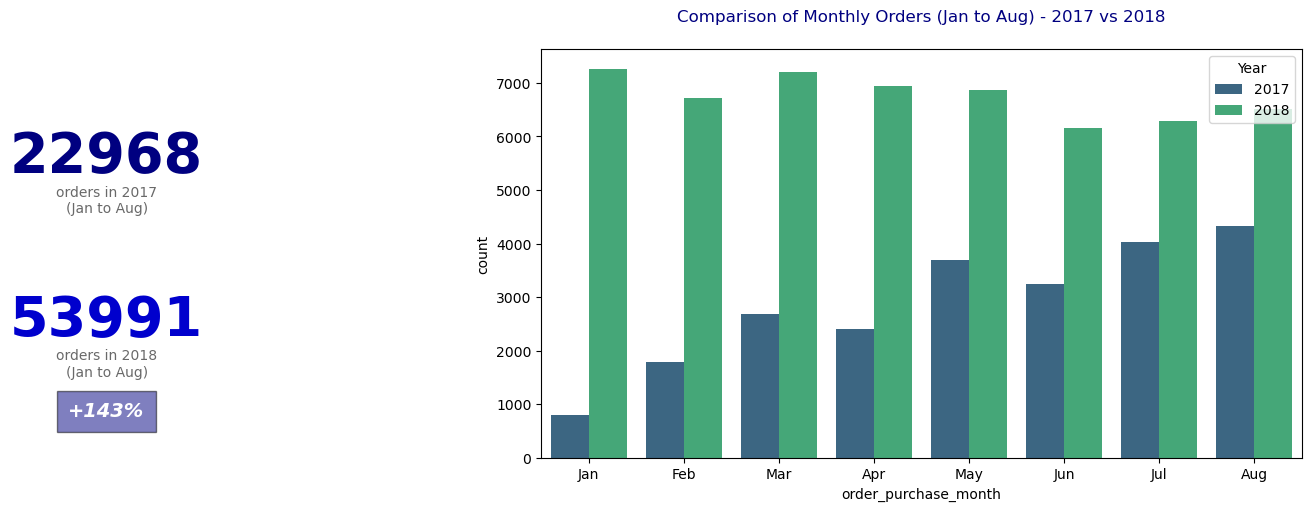

In [11]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(13, 5))

# Axis definition
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])

# Annotation - Growth on e-commerce orders between 2017 and 2018
olist_orders_compare = olist_orders_dataset.query('order_purchase_year in (2017, 2018) & order_purchase_month <= 8')
year_orders = olist_orders_compare['order_purchase_year'].value_counts()
growth = int(round(100 * (1 + year_orders[2017] / year_orders[2018]), 0))

ax1.text(0.05, 0.7, f'{year_orders[2017]}', fontsize=40, color='navy', ha='center', fontweight='bold')
ax1.text(0.05, 0.6, 'orders in 2017\n(Jan to Aug)', fontsize=10, ha='center', color='dimgrey')
ax1.text(0.05, 0.3, f'{year_orders[2018]}', fontsize=40, color='mediumblue', ha='center', fontweight='bold')
ax1.text(0.05, 0.2, 'orders in 2018\n(Jan to Aug)', fontsize=10, ha='center', color='dimgrey')
signal = '+' if growth > 0 else '-'
ax1.text(0.05, 0.1, f'{signal}{growth}%', fontsize=14, ha='center', color='white', style='italic', fontweight='bold', bbox=dict(facecolor='navy', alpha=0.5, pad=8))

ax1.axis('off')

# Bar chart - Comparison between monthly sales between 2017 and 2018
sns.countplot(data=olist_orders_compare, x='order_purchase_month', hue='order_purchase_year', ax=ax2, palette='viridis')
month_label = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
ax2.set_xticklabels(month_label)
ax2.set_title('Comparison of Monthly Orders (Jan to Aug) - 2017 vs 2018', size=12, color='navy', pad=20)
ax2.legend(loc='upper right', title='Year')  # Legend placement

plt.show()

In [12]:
# Merging orders and order_items
olist_orders_dataset = olist_orders_dataset.merge(olist_customers_dataset, how='left', on='customer_id')
olist_orders_dataset = olist_orders_dataset.merge(olist_order_items_dataset, how='left', on='order_id')
# Using the API to bring the region to the data
r = requests.get('https://servicodados.ibge.gov.br/api/v1/localidades/mesorregioes')
content = [c['UF'] for c in json.loads(r.text)]
br_info = pd.DataFrame(content)
br_info['nome_regiao'] = br_info['regiao'].apply(lambda x: x['nome'])
br_info.drop('regiao', axis=1, inplace=True)
br_info.drop_duplicates(inplace=True)

# Threting geolocations outside brazilian map

#Brazils most Northern spot is at 5 deg 16′ 27.8″ N latitude.;
geo_prep = olist_geolocation_dataset[olist_geolocation_dataset.geolocation_lat <= 5.27438888]
#it’s most Western spot is at 73 deg, 58′ 58.19″W Long.
geo_prep = geo_prep[geo_prep.geolocation_lng >= -73.98283055]
#It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude.
geo_prep = geo_prep[geo_prep.geolocation_lat >= -33.75116944]
#It’s most Eastern spot is 34 deg, 47′ 35.33″ W Long.
geo_prep = geo_prep[geo_prep.geolocation_lng <=  -34.79314722]
geo_group = geo_prep.groupby(by='geolocation_zip_code_prefix', as_index=False).min()

# Merging all the informations
olist_orders_dataset = olist_orders_dataset.merge(br_info, how='left', left_on='customer_state', right_on='sigla')
olist_orders_dataset = olist_orders_dataset.merge(geo_group, how='left', left_on='customer_zip_code_prefix', 
                                        right_on='geolocation_zip_code_prefix')
olist_orders_dataset.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  order_purchase_year  order_purchase_month  \
0                    2017-10-18                 2017                    10   
1                    2018-08-13                 2018                     7   
2                    2018-09-04                 2018                     8   
3                    2017-12-15                 2017                    11   
4                    2018-02-26                 2018                     2   

  order_purchase_month_name order_purchase_year_month order_purchase_date  \
0                       Oct                    201710            20171002   
1                       Jul                    201807            20180724   
2                       Aug                    201808            20180808   
3                       Nov                    201711            20171118   
4                       Feb                    201802            20180213   

   order_purchase_day  order_purchase_dayofweek order_purchase_dayofweek_name  \
0                   2                         0                           Mon   
1                  24                         1                           Tue   
2                   8                         2                           Wed   
3                  18                         5                           Sat   
4                  13                         1                           Tue   

   order_purchase_hour order_purchase_time_day  \
0                   10                 Morning   
1                   20                   Night   
2                    8                 Morning   
3                   19                   Night   
4                   21                   Night   

                 customer_unique_id  customer_zip_code_prefix  \
0  7c396fd4830fd04220f754e42b4e5bff                      3149   
1  af07308b275d755c9edb36a90c618231                     47813   
2  3a653a41f6f9fc3d2a113cf8398680e8                     75265   
3  7c142cf63193a1473d2e66489a9ae977                     59296   
4  72632f0f9dd73dfee390c9b22eb56dd6                      9195   

             customer_city customer_state  order_item_id  \
0                sao paulo             SP            1.0   
1                barreiras             BA            1.0   
2               vianopolis             GO            1.0   
3  sao goncalo do amarante             RN            1.0   
4              santo andre             SP            1.0   

                         product_id                         seller_id  \
0  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
1  595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962   
2  aa4383b373c6aca5d8797843e5594415  4869f7a5dfa277a7dca6462dcf3b52b2   
3  d0b61bfb1de832b15ba9d266ca96e5b0  66922902710d126a0

In [13]:
# Filtering data between 201701 and 201808
df_orders_filt = olist_orders_dataset[(olist_orders_dataset['order_purchase_year_month'].astype(int) >= 201701)]
df_orders_filt = df_orders_filt[(df_orders_filt['order_purchase_year_month'].astype(int) <= 201808)]

# Grouping data by region
df_regions_group = df_orders_filt.groupby(by=['order_purchase_year_month', 'nome_regiao'], as_index=False)
df_regions_group = df_regions_group.agg({'customer_id': 'count', 'price': 'sum'}).sort_values(by='order_purchase_year_month')
df_regions_group.columns = ['month', 'region', 'order_count', 'order_amount']
df_regions_group.reset_index(drop=True, inplace=True)

# Grouping data by city (top 10)
df_cities_group = df_orders_filt.groupby(by='geolocation_city', 
                                       as_index=False).count().loc[:, ['geolocation_city', 'order_id']]
df_cities_group = df_cities_group.sort_values(by='order_id', ascending=False).reset_index(drop=True)
df_cities_group = df_cities_group.iloc[:10, :]

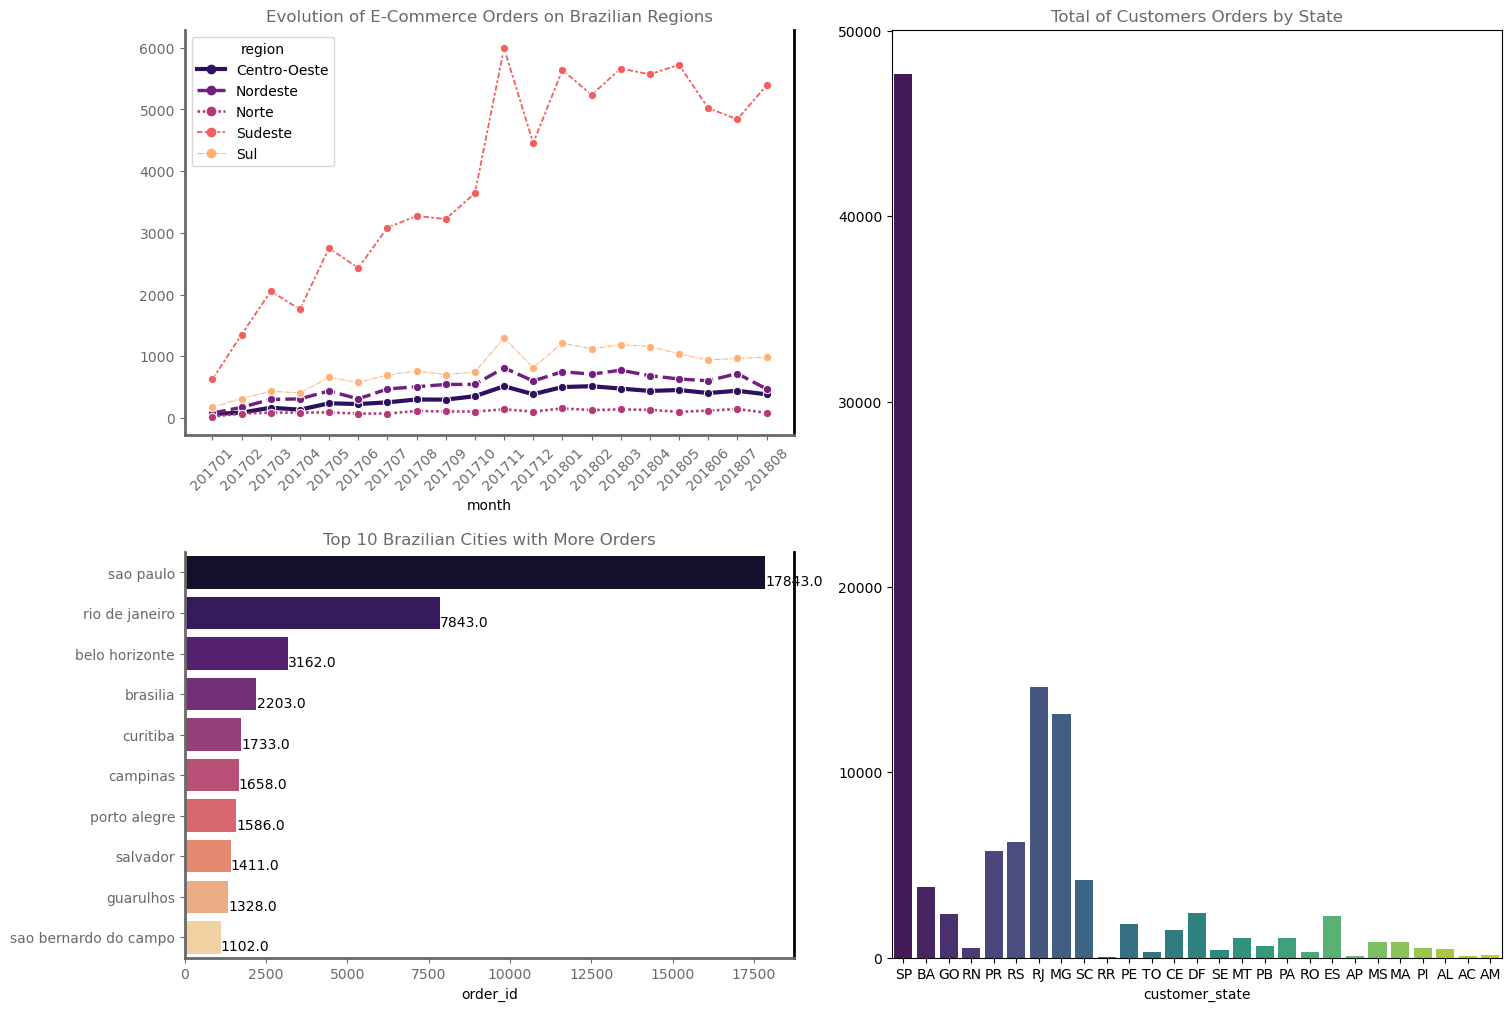

In [14]:
class AnnotateBars:
    def __init__(self, n_dec=0, font_size=10, color='black'):
        self.n_dec = n_dec
        self.font_size = font_size
        self.color = color

    def horizontal(self, ax, space=5):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()
            value = round(p.get_width(), self.n_dec)
            ax.text(_x, _y, f'{value}', ha="left", va='bottom', fontsize=self.font_size, color=self.color)

# Creating and preparing figure and axis
fig = plt.figure(constrained_layout=True, figsize=(15, 10))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])

# Count of orders by region
sns.lineplot(x='month', y='order_count', ax=ax1, data=df_regions_group, hue='region', 
             size='region', style='region', palette='magma', markers=['o'] * 5)
format_spines(ax1, right_border=False)
ax1.set_title('Evolution of E-Commerce Orders on Brazilian Regions', size=12, color='dimgrey')
ax1.set_ylabel('')
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)

# Top cities with more customers orders in Brazil
sns.barplot(y='geolocation_city', x='order_id', data=df_cities_group, ax=ax2, palette='magma')
AnnotateBars(n_dec=0, font_size=10, color='black').horizontal(ax2)
format_spines(ax2, right_border=False)
ax2.set_title('Top 10 Brazilian Cities with More Orders', size=12, color='dimgrey')
ax2.set_ylabel('')

# Total orders by state
single_countplot(data=df_orders_filt, x='customer_state', ax=ax3, palette='viridis')
ax3.set_title('Total of Customers Orders by State', size=12, color='dimgrey')
ax3.set_ylabel('')


plt.show()

In [15]:
# Zipping locations
lats = list(olist_orders_dataset.query('order_purchase_year == 2018')['geolocation_lat'].dropna().values)[:30000]
longs = list(olist_orders_dataset.query('order_purchase_year == 2018')['geolocation_lng'].dropna().values)[:30000]
locations = list(zip(lats, longs))

# Creating a mapa using folium
map1 = folium.Map(location=[-15, -50], zoom_start=4.0)

# Plugin: FastMarkerCluster
FastMarkerCluster(data=locations).add_to(map1)

map1

In [16]:
# Grouping geolocation data for plotting a heatmap
heat_data = df_orders_filt.groupby(by=['geolocation_lat', 'geolocation_lng'], as_index=False).count().iloc[:, :3]

# Creating a mapa using folium
map1 = folium.Map(
    location=[-15, -50], 
    zoom_start=4.0, 
    tiles='cartodbdark_matter'
)

# Plugin: HeatMap
HeatMap(
    name='Mapa de Calor',
    data=heat_data,
    radius=10,
    max_zoom=13
).add_to(map1)

map1

In [17]:
epoch_list = []
heatmap_evl_data = olist_orders_dataset[(olist_orders_dataset['order_purchase_year_month'].astype(int) >= 201801)]
heatmap_evl_data = heatmap_evl_data[(heatmap_evl_data['order_purchase_year_month'].astype(int) <= 201807)]
time_index = heatmap_evl_data['order_purchase_year_month'].sort_values().unique()
for epoch in time_index:
    data_temp = heatmap_evl_data.query('order_purchase_year_month == @epoch')
    data_temp = data_temp.groupby(by=['geolocation_lat', 'geolocation_lng'], as_index=False).count()
    data_temp = data_temp.sort_values(by='order_id', ascending=False).iloc[:, :3]
    epoch_list.append(data_temp.values.tolist())
    
# Creating a mapa using folium
map2 = folium.Map(
    location=[-15, -50], 
    zoom_start=4.0, 
    tiles='cartodbdark_matter'
)

# Plugin: HeatMapWithTime
HeatMapWithTime(
    name='Evolution of Orders in a Geolocation Perspective',
    data=epoch_list,
    radius=10,
    index=list(time_index)
).add_to(map2)

map2

In [18]:
# Grouping data
df_month_aggreg = df_orders_filt.groupby(by=['order_purchase_year', 'order_purchase_year_month'], as_index=False)
df_month_aggreg = df_month_aggreg.agg({
    'order_id': 'count',
    'price': 'sum',
    'freight_value': 'sum'
})

# Adding new columns for analysis
df_month_aggreg['price_per_order'] = df_month_aggreg['price'] / df_month_aggreg['order_id']
df_month_aggreg['freight_per_order'] = df_month_aggreg['freight_value'] / df_month_aggreg['order_id']
df_month_aggreg.head()

order_purchase_year order_purchase_year_month  order_id      price  \
0                 2017                    201701       966  120312.87   
1                 2017                    201702      1998  247303.02   
2                 2017                    201703      3041  374344.30   
3                 2017                    201704      2697  359927.23   
4                 2017                    201705      4176  506071.14   

   freight_value  price_per_order  freight_per_order  
0       16875.62       124.547484          17.469586  
1       38977.60       123.775285          19.508308  
2       57704.29       123.099079          18.975432  
3       52495.01       133.454664          19.464223  
4       80119.81       121.185618          19.185778

/var/folders/89/0r9qyh0n08b8ytzm9swqrl_80000gn/T/ipykernel_23902/3802948114.py:61: UserWarning:

The figure layout has changed to tight



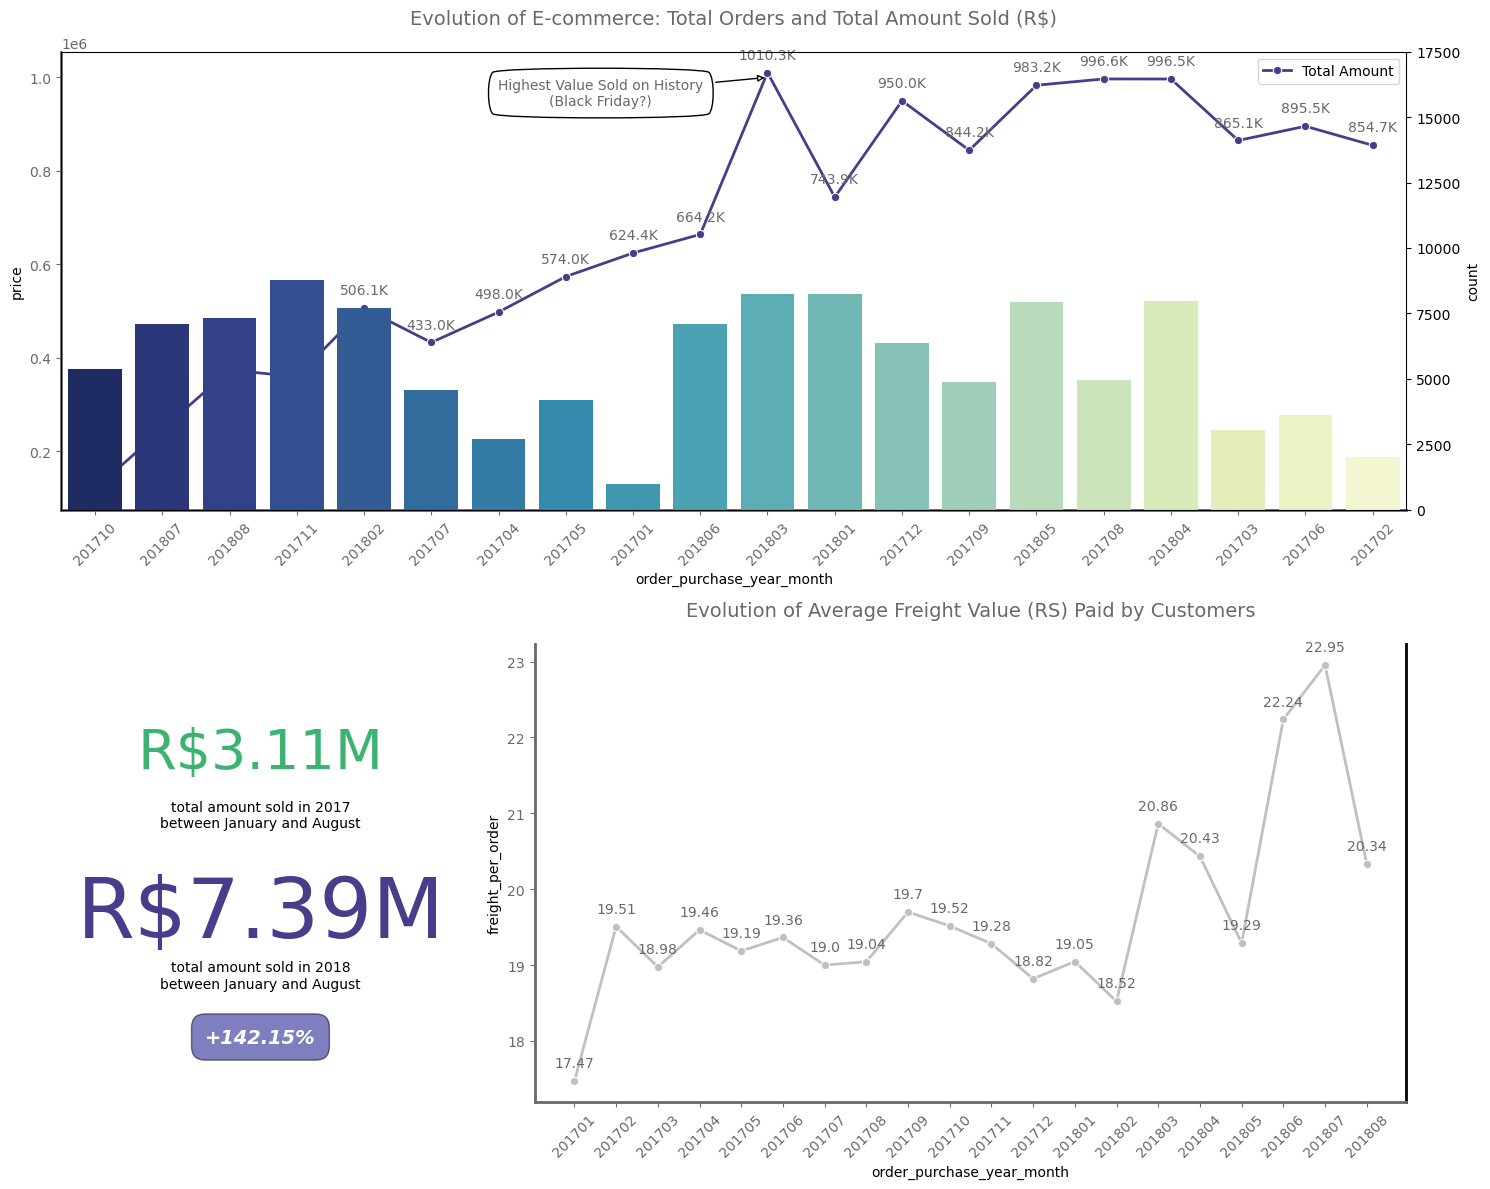

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Creating figure and defining axes
fig = plt.figure(constrained_layout=True, figsize=(15, 12))
gs = GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1:])

# Plot 1 - Evolution of total orders and total sales on e-commerce
sns.lineplot(x='order_purchase_year_month', y='price', ax=ax1, data=df_month_aggreg, linewidth=2, 
             color='darkslateblue', marker='o', label='Total Amount')
ax1_twx = ax1.twinx()
single_countplot(df_orders_filt, x='order_purchase_year_month', ax=ax1_twx, palette='YlGnBu_r')
ax1_twx.set_yticks(np.arange(0, 20000, 2500))

# Customizing the first plot
format_spines(ax1)
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
for x, y in df_month_aggreg.price.items():
    ax1.annotate(str(round(y/1000, 1))+'K', xy=(x, y), textcoords='offset points', xytext=(0, 10),
                ha='center', color='dimgrey')
ax1.annotate(f'Highest Value Sold on History\n(Black Friday?)', (10, 1000000), xytext=(-120, -20), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.set_title('Evolution of E-commerce: Total Orders and Total Amount Sold (R$)', size=14, color='dimgrey', pad=20)

# Plot 2 - Big Numbers of Sales Evolution
month_comparison = ['201701', '201702', '201703', '201704', '201705', '201706', '201707', '201708',
                    '201801', '201802', '201803', '201804', '201805', '201806', '201807', '201808']
df_sales_compare = df_month_aggreg.query('order_purchase_year_month in (@month_comparison)')
sold_2017 = df_sales_compare.query('order_purchase_year == 2017')['price'].sum()
sold_2018 = df_sales_compare.query('order_purchase_year == 2018')['price'].sum()
growth = 1 + (sold_2017 / sold_2018)

# Plot 2 annotation texts and styles
ax2.text(0.50, 0.73, 'R$' + str(round(sold_2017/1000000, 2)) + 'M', fontsize=40, color='mediumseagreen', ha='center')
ax2.text(0.50, 0.60, 'total amount sold in 2017\nbetween January and August', fontsize=10, ha='center')
ax2.text(0.50, 0.36, 'R$' + str(round(sold_2018/1000000, 2)) + 'M', fontsize=60, color='darkslateblue', ha='center')
ax2.text(0.50, 0.25, 'total amount sold in 2018\nbetween January and August', fontsize=10, ha='center')
signal = '+' if growth > 0 else '-'
ax2.text(0.50, 0.13, f'{signal}{str(round(100 * growth, 2))}%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='navy', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax2.axis('off')

# Plot 3 - Evolution of mean freight value paid by the customers
sns.lineplot(x='order_purchase_year_month', y='freight_per_order', data=df_month_aggreg, linewidth=2, 
             color='silver', marker='o', ax=ax3)
format_spines(ax3, right_border=False)
for tick in ax3.get_xticklabels():
    tick.set_rotation(45)
for x, y in df_month_aggreg.freight_per_order.items():
    ax3.annotate(round(y, 2), xy=(x, y), textcoords='offset points', xytext=(0, 10),
                ha='center', color='dimgrey')
ax3.set_title('Evolution of Average Freight Value (RS) Paid by Customers', size=14, color='dimgrey', pad=20)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()